##Objective:
The primary goal of this analysis is to employ machine learning techniques to accurately predict the occurrence of heart disease in individuals. By leveraging the Decision Tree Classifier—a versatile and interpretable model—we aim to uncover patterns and relationships within the data that contribute to heart disease risk.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, recall_score, precision_score, classification_report
import joblib

import warnings
warnings.filterwarnings("ignore")

## Define functions


In [50]:
def iqr_outliers(df):
    out=[]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    return out, len(out)

def Zscore_outlier(df):
    out=[]
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out.append(i)
    return out, len(out)


def percentile_capping_with_winsorize(df, cols, from_low_end, from_high_end):
    
    # Capping the values in specified columns of a DataFrame to a given percentile range using winsorization.
    
    #Parameters:
    # df: DataFrame to be modified.
    # cols: List of column names to apply capping.
    # from_low_end: Lower percentile threshold for capping.
    # from_high_end: Upper percentile threshold for capping.
    
    #Returns:
    #DataFrame with capped values in specified columns.
    for col in cols:
        # Winsorizing is done in-place, so directly modifying the column.
        # Directly update the DataFrame column with the winsorized data
        df[col] = stats.mstats.winsorize(df[col].values, limits=(from_low_end, from_high_end))


def percentile_capping(df, cols, from_low_end, from_high_end):
    """
    Caps the values in specified columns of a DataFrame to a given percentile range.
    
    Parameters:
    - df: DataFrame to be modified.
    - cols: List of column names to apply capping.
    - from_low_end: Lower percentile threshold for capping.
    - from_high_end: Upper percentile threshold for capping.
    
    Returns:
    - DataFrame with capped values in specified columns.
    """
    for col in cols:
        lower_bound = df[col].quantile(from_low_end)
        upper_bound = df[col].quantile(1 - from_high_end)
        df[col] = np.where(df[col] > upper_bound, upper_bound, 
                           np.where(df[col] < lower_bound, lower_bound, df[col]))
    

    


def GrdSrch_Tune(model, X, y, params):
    
    clf = GridSearchCV(model, params, scoring ='accuracy', cv = 5, n_jobs=-1)
    clf.fit(X, y)
    
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    
    return (clf.best_score_)


## Data understanding and EDA

In [6]:
df = pd.read_csv('/Users/venus/Documents/Data Science BOOTCAMP/Python/2/Heart data.csv')
df.head()
df.shape

(597, 14)

In [7]:
df_test = pd.read_csv(r"/Users/venus/Documents/Data Science BOOTCAMP/Python/4/heart data project/Heart data_test.csv")
df_test.head()
df_test.shape

(18, 13)

In [9]:
# Define a dictionary for column renaming
df = df.rename(columns = {'Age (age in year)':'Age',
                          'chest pain':'chest_pain',
                          'blood pressure':'blood_pressure',
                          'cholestoral ':'cholestoral',
                          'blood sugar':'blood_sugar',
                          'electrocardiographic ':'electrocardiographic',
                          'heart rate':'heart_rate',
                          'exercise induced':'exercise_induced',
                          'depression ':'depression'})

# Apply the renaming to both DataFrames
df_test = df_test.rename(columns = {'Age (age in year)':'Age',
                          'chest pain':'chest_pain',
                          'blood pressure':'blood_pressure',
                          'cholestoral ':'cholestoral',
                          'blood sugar':'blood_sugar',
                          'electrocardiographic ':'electrocardiographic',
                          'heart rate':'heart_rate',
                          'exercise induced':'exercise_induced',
                          'depression ':'depression'})
df.head()

,Age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,electrocardiographic,heart_rate,exercise_induced,depression,slope,ca,thal,c
0,63,1,1,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,37,1,3,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
2,41,0,2,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
3,56,1,2,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
4,57,0,4,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0


## Data Preparation and Analysis
In this section, we will perform the following operations on our dataset:

Split the Dataset: Divide the data into training and test sets to prepare for model training and evaluation.

Examine Outliers and Errors in the Training Set: Identify and address any outliers or errors in the training data to improve model accuracy.

Check for Missing Data: Inspect the training set for missing values and decide on a strategy for handling them (e.g., imputation or removal).

Implement Normalization: Apply normalization to the training data to standardize the scale of the data features.

Validation with the Test Set: Validate the normalization and other preprocessing steps by applying the same transformations to the test set and ensuring consistency.

In [10]:
df_train, df_val = train_test_split(df, random_state =0 , test_size = 0.2)
print(df_train.shape)
print(df_val.shape)

(477, 14)
(120, 14)


In [11]:
print("Train:")
print(df_train.shape)
print(" ")

print("Val:")
print(df_val.shape)
print(" ")

print("Test:")
print(df_test.shape)

Train:
(477, 14)
 
Val:
(120, 14)
 
Test:
(18, 13)


In [12]:
print("Train:")
print(df_train.columns)
print("\n\n")
print("Val:")
print(df_val.columns)
print("\n \n")
print("Test:")
print(df_test.columns)

Train:
Index(['Age', 'sex', 'chest_pain', 'blood_pressure', 'cholestoral',
       'blood_sugar', 'electrocardiographic', 'heart_rate', 'exercise_induced',
       'depression', 'slope', 'ca', 'thal', 'c'],
      dtype='object')



Val:
Index(['Age', 'sex', 'chest_pain', 'blood_pressure', 'cholestoral',
       'blood_sugar', 'electrocardiographic', 'heart_rate', 'exercise_induced',
       'depression', 'slope', 'ca', 'thal', 'c'],
      dtype='object')

 

Test:
Index(['Age', 'sex', 'chest_pain', 'blood_pressure', 'cholestoral',
       'blood_sugar', 'electrocardiographic', 'heart_rate', 'exercise_induced',
       'depression', 'slope', 'ca', 'thal'],
      dtype='object')


In [14]:
print("Train:")
print(df_train.info())
print("\n \n")
print("Val:")
print(df_val.info())
print("\n \n")
print("Test:")
print(df_test.info())

Train:
<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, 239 to 559
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   477 non-null    int64  
 1   sex                   477 non-null    int64  
 2   chest_pain            477 non-null    int64  
 3   blood_pressure        476 non-null    float64
 4   cholestoral           457 non-null    float64
 5   blood_sugar           471 non-null    float64
 6   electrocardiographic  476 non-null    float64
 7   heart_rate            476 non-null    float64
 8   exercise_induced      476 non-null    float64
 9   depression            477 non-null    float64
 10  slope                 328 non-null    float64
 11  ca                    240 non-null    float64
 12  thal                  263 non-null    float64
 13  c                     477 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 55.9 KB
None

 

Val:
<class 'p

In [15]:
print("Train:")
print(df_train.isnull().sum())
print("\n*********************\n")
print("Val:")
print(df_val.isnull().sum())
print("\n*********************\n")
print("Test:")
print(df_test.isnull().sum())

Train:
Age                       0
sex                       0
chest_pain                0
blood_pressure            1
cholestoral              20
blood_sugar               6
electrocardiographic      1
heart_rate                1
exercise_induced          1
depression                0
slope                   149
ca                      237
thal                    214
c                         0
dtype: int64

*********************

Val:
Age                      0
sex                      0
chest_pain               0
blood_pressure           0
cholestoral              3
blood_sugar              2
electrocardiographic     0
heart_rate               0
exercise_induced         0
depression               0
slope                   41
ca                      57
thal                    54
c                        0
dtype: int64

*********************

Test:
Age                     0
sex                     0
chest_pain              0
blood_pressure          0
cholestoral             0
blood_su

In [16]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,477.0,51.255765,9.232614,29.0,44.0,52.0,58.0,77.0
sex,477.0,0.698113,0.459558,0.0,0.0,1.0,1.0,1.0
chest_pain,477.0,3.071279,0.967515,1.0,2.0,3.0,4.0,4.0
blood_pressure,476.0,132.296218,17.609282,92.0,120.0,130.0,140.0,200.0
cholestoral,457.0,249.083151,55.600960,85.0,212.0,244.0,280.0,529.0
blood_sugar,471.0,0.104034,0.305629,0.0,0.0,0.0,0.0,1.0
electrocardiographic,476.0,0.623950,0.875018,0.0,0.0,0.0,2.0,2.0
heart_rate,476.0,144.256303,23.885725,71.0,127.0,147.0,162.0,202.0
exercise_induced,476.0,0.315126,0.465055,0.0,0.0,0.0,1.0,1.0
depression,477.0,0.806080,1.044144,0.0,0.0,0.2,1.5,6.2


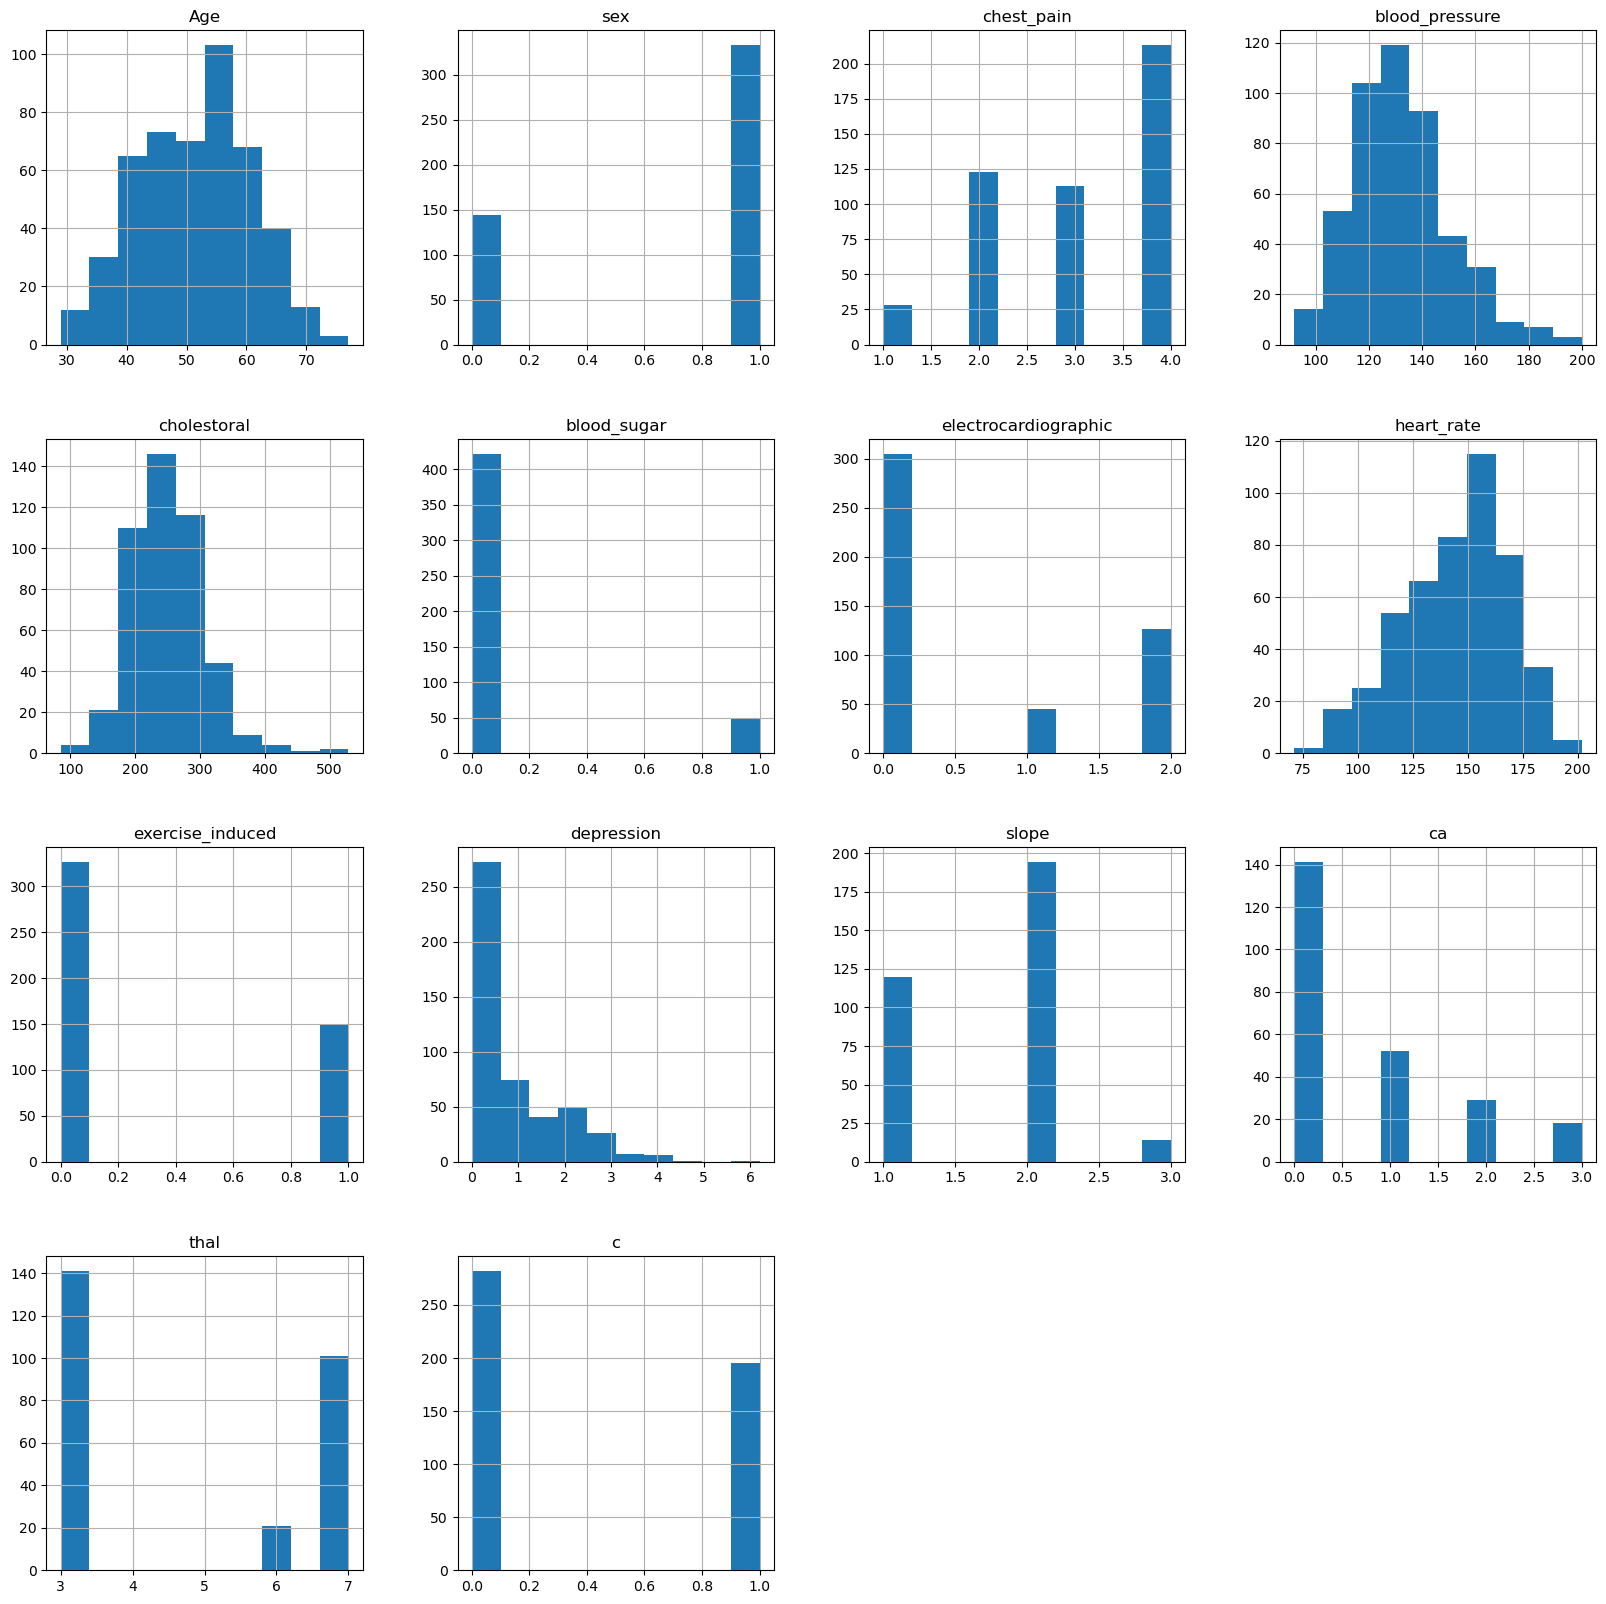

In [18]:
# Generate histograms for each numerical column in df_train to visually assess the distributions.
# This aids in identifying skewness, outliers, and understanding the data's central tendency and dispersion.
# Useful for preliminary data analysis,feature selection/engineering, and preprocessing decisions.
p = df_train.hist(figsize=(20,20))

c
0    282
1    195
Name: count, dtype: int64

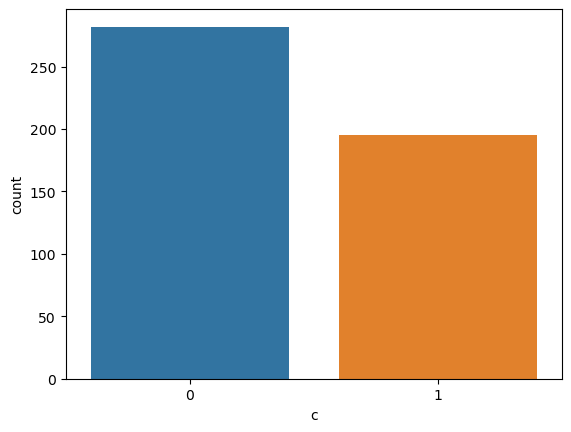

In [19]:
# using visualization for the distribution of the target variable 'c' to assess class balance and inform preprocessing.
# sns.countplot provides a clear visual representation of class frequencies, aiding in model selection strategies.
sns.countplot(x='c', data=df_train)

# Using value_counts to get a precise count of instances in each class of the target variable 'c'.
# Essential for identifying class imbalance and guiding decisions on resampling techniques or specialized modeling approaches.
df_train.loc[:, 'c'].value_counts()


## Preprocessing


### Handling Outliers

In [20]:
col_names = df_train.columns

# ---------------------------
col_names_val = df_val.columns

# ---------------------------
col_names_test = df_test.columns

In [22]:
print("Train: ")
outlier = []

for c in col_names:
    _, len_outlier_train = iqr_outliers(df_train[c])
    _, len_outlier_z_score_train = Zscore_outlier(df_train[c])
    
    if len_outlier_train !=0:
        outlier.append(c)
    print("IQR ->", c,": " , len_outlier_train)
    print("Z-score ->",c,": " , len_outlier_z_score_train)
    print("*****************")
    print(outlier)

Train: 
IQR -> Age :  0
Z-score -> Age :  0
*****************
[]
IQR -> sex :  0
Z-score -> sex :  0
*****************
[]
IQR -> chest_pain :  0
Z-score -> chest_pain :  0
*****************
[]
IQR -> blood_pressure :  13
Z-score -> blood_pressure :  3
*****************
['blood_pressure']
IQR -> cholestoral :  13
Z-score -> cholestoral :  4
*****************
['blood_pressure', 'cholestoral']
IQR -> blood_sugar :  49
Z-score -> blood_sugar :  0
*****************
['blood_pressure', 'cholestoral', 'blood_sugar']
IQR -> electrocardiographic :  0
Z-score -> electrocardiographic :  0
*****************
['blood_pressure', 'cholestoral', 'blood_sugar']
IQR -> heart_rate :  1
Z-score -> heart_rate :  1
*****************
['blood_pressure', 'cholestoral', 'blood_sugar', 'heart_rate']
IQR -> exercise_induced :  0
Z-score -> exercise_induced :  0
*****************
['blood_pressure', 'cholestoral', 'blood_sugar', 'heart_rate']
IQR -> depression :  8
Z-score -> depression :  7
*****************
['blood

In [25]:
# Initialize an empty list to track columns where outliers are detected.
# Prioritizing IQR for outlier detection due to its robustness in handling skewed distributions.
# The IQR method is preferred here as it's less sensitive to extreme outliers, making it a conservative choice
# that helps retain more data for analysis, especially valuable in datasets with non-normal distributions.
outlier = []

# Loop through each column name in 'col_names'.
for column in col_names:
    # Use the IQR method to identify and count outliers in the current column.
    _, len_outlier_train = iqr_outliers(df_train[column])
    # Use the Z-score method to identify and count outliers in the same column.
    _, len_outlier_z_score_train = Zscore_outlier(df_train[column])
    
    # If the IQR method detects any outliers, add the column name to the 'outlier' list.
    if len_outlier_train != 0:
        outlier.append(column)
    
    # Print the count of outliers found using the IQR method for the current column.
    print("IQR ->", column, ":", len_outlier_train)
    # Print the count of outliers found using the Z-score method for the same column.
    print("Z-score ->", column, ":", len_outlier_z_score_train)
    print("*****************")
    
# After the loop, print the list of columns with outliers detected by the IQR method.
print("Columns with outliers:", outlier)


IQR -> Age : 0
Z-score -> Age : 0
*****************
IQR -> sex : 0
Z-score -> sex : 0
*****************
IQR -> chest_pain : 0
Z-score -> chest_pain : 0
*****************
IQR -> blood_pressure : 13
Z-score -> blood_pressure : 3
*****************
IQR -> cholestoral : 13
Z-score -> cholestoral : 4
*****************
IQR -> blood_sugar : 49
Z-score -> blood_sugar : 0
*****************
IQR -> electrocardiographic : 0
Z-score -> electrocardiographic : 0
*****************
IQR -> heart_rate : 1
Z-score -> heart_rate : 1
*****************
IQR -> exercise_induced : 0
Z-score -> exercise_induced : 0
*****************
IQR -> depression : 8
Z-score -> depression : 7
*****************
IQR -> slope : 0
Z-score -> slope : 0
*****************
IQR -> ca : 18
Z-score -> ca : 0
*****************
IQR -> thal : 0
Z-score -> thal : 0
*****************
IQR -> c : 0
Z-score -> c : 0
*****************
Columns with outliers: ['blood_pressure', 'cholestoral', 'blood_sugar', 'heart_rate', 'depression', 'ca']


In [26]:
print("Val:")

# Initialize a list to store columns from the validation set where outliers are detected
outlier_val = []

# Loop through each column name in 'col_names_val' to assess for outliers
for column in col_names_val:
    # Use the IQR method to identify and count outliers in the current column of the validation set
    _, len_outlier_val = iqr_outliers(df_val[column])
    # Use the Z-score method to identify and count outliers in the same column of the validation set
    _, len_outlier_z_score_val = Zscore_outlier(df_val[column])
    
    # If the IQR method detects any outliers, add the column name to the 'outlier_val' list
    if len_outlier_val != 0:
        outlier_val.append(column)
    
    # Print the number of outliers detected using the IQR method for the current column
    print("IQR ->", column, ":", len_outlier_val)
    # Print the number of outliers detected using the Z-score method for the same column
    print("Z-score ->", column, ":", len_outlier_z_score_val)
    print("Columns with outliers detected by IQR method in the validation set:", outlier_val)
    print("*****************")


Val:
IQR -> Age : 0
Z-score -> Age : 0
Columns with outliers detected by IQR method in the validation set: []
*****************
IQR -> sex : 0
Z-score -> sex : 0
Columns with outliers detected by IQR method in the validation set: []
*****************
IQR -> chest_pain : 0
Z-score -> chest_pain : 0
Columns with outliers detected by IQR method in the validation set: []
*****************
IQR -> blood_pressure : 4
Z-score -> blood_pressure : 1
Columns with outliers detected by IQR method in the validation set: ['blood_pressure']
*****************
IQR -> cholestoral : 6
Z-score -> cholestoral : 3
Columns with outliers detected by IQR method in the validation set: ['blood_pressure', 'cholestoral']
*****************
IQR -> blood_sugar : 16
Z-score -> blood_sugar : 0
Columns with outliers detected by IQR method in the validation set: ['blood_pressure', 'cholestoral', 'blood_sugar']
*****************
IQR -> electrocardiographic : 0
Z-score -> electrocardiographic : 0
Columns with outliers detec

In [27]:
print("Test:")

# Initialize a list to store columns from the test set where outliers are detected using the IQR method.
outlier_test = []

# Iterate over each column name in 'col_names_test' to assess for outliers.
for column in col_names_test:
    # Use the IQR method to identify and count outliers in the current column of the test set.
    _, len_outlier_test = iqr_outliers(df_test[column])
    # Use the Z-score method to identify and count outliers in the same column of the test set.
    _, len_outlier_z_score_test = Zscore_outlier(df_test[column])
    
    # If the IQR method detects any outliers, add the column name to the 'outlier_test' list.
    if len_outlier_test != 0:
        outlier_test.append(column)
    
    # Print the number of outliers detected using the IQR method for the current column.
    print("IQR ->", column, ":", len_outlier_test)
    # Print the number of outliers detected using the Z-score method for the same column.
    print("Z-score ->", column, ":", len_outlier_z_score_test)
    print("*****************")

Test:
IQR -> Age : 0
Z-score -> Age : 0
*****************
IQR -> sex : 0
Z-score -> sex : 0
*****************
IQR -> chest_pain : 0
Z-score -> chest_pain : 0
*****************
IQR -> blood_pressure : 0
Z-score -> blood_pressure : 0
*****************
IQR -> cholestoral : 0
Z-score -> cholestoral : 0
*****************
IQR -> blood_sugar : 0
Z-score -> blood_sugar : 0
*****************
IQR -> electrocardiographic : 0
Z-score -> electrocardiographic : 0
*****************
IQR -> heart_rate : 2
Z-score -> heart_rate : 0
*****************
IQR -> exercise_induced : 0
Z-score -> exercise_induced : 0
*****************
IQR -> depression : 0
Z-score -> depression : 0
*****************
IQR -> slope : 0
Z-score -> slope : 0
*****************
IQR -> ca : 1
Z-score -> ca : 0
*****************
IQR -> thal : 0
Z-score -> thal : 0
*****************


In [28]:
# Initialize an empty list to store the names of features for outlier handling
goal_features = []

# Iterate over each column in the DataFrame to evaluate its unique value count
for c in df.columns:
    print(c)
    # Print the number of unique values in the current column
    print(len(df[c].unique()))
    
    # Select columns with more than 6 unique values for outlier handling
    # Rationale:
    # - Columns with more than 6 unique values are likely to be continuous or semi-continuous,
    #   which are more susceptible to outliers that can skew data analysis and model performance.
    # - Handling outliers in these variables can improve data quality by minimizing the impact
    #   of extreme values on statistical calculations and machine learning algorithms.
    if len(df[c].unique()) > 6:
        goal_features.append(c)
    
    print("*************")

print("----------------------")
# Print the list of selected features for outlier handling
print(goal_features)


Age
47
*************
sex
2
*************
chest_pain
4
*************
blood_pressure
55
*************
cholestoral
202
*************
blood_sugar
3
*************
electrocardiographic
4
*************
heart_rate
104
*************
exercise_induced
3
*************
depression
41
*************
slope
4
*************
ca
6
*************
thal
4
*************
c
2
*************
----------------------
['Age', 'blood_pressure', 'cholestoral', 'heart_rate', 'depression']


In [29]:
outlier_new_win = ['blood_pressure', 'cholestoral', 'heart_rate', 'depression']

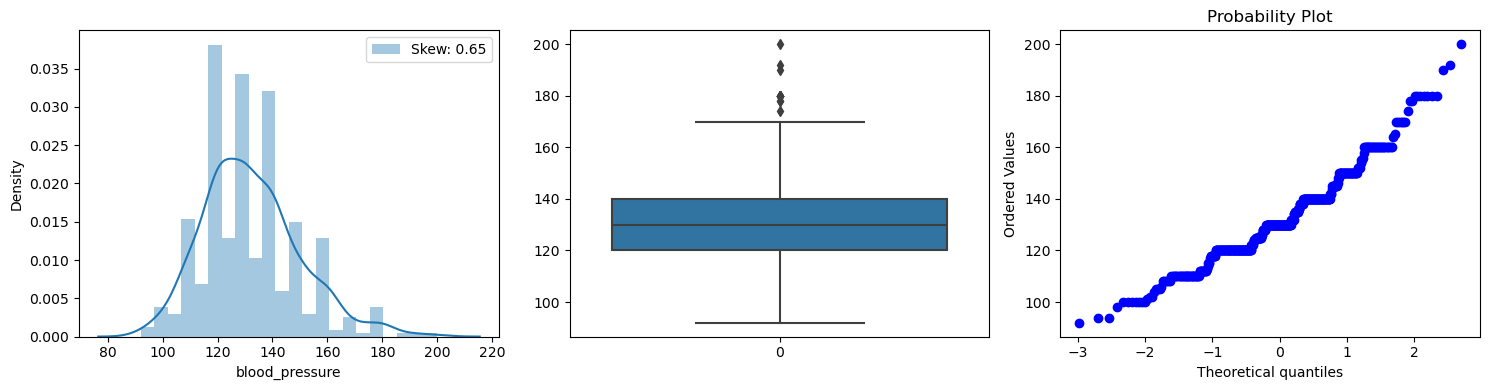

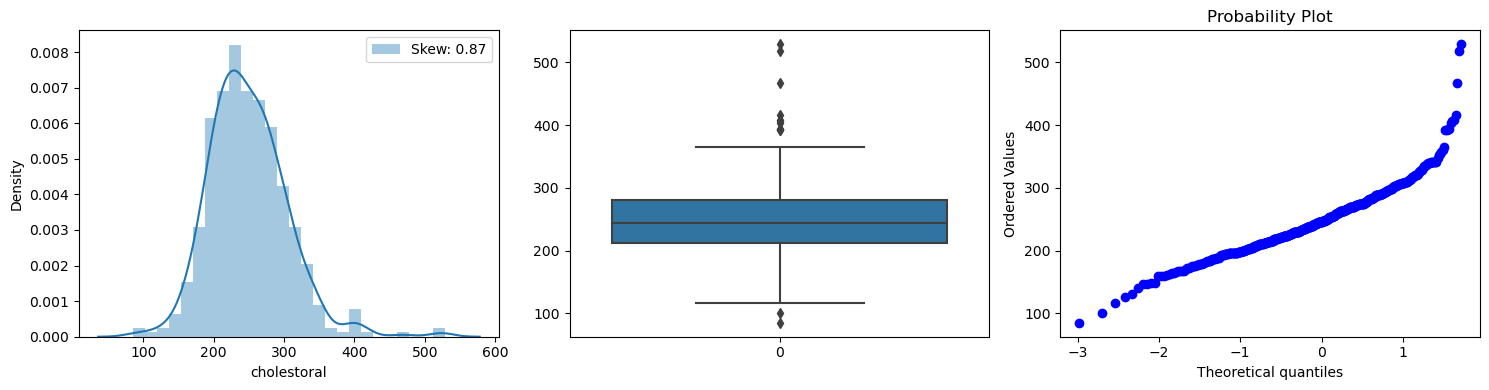

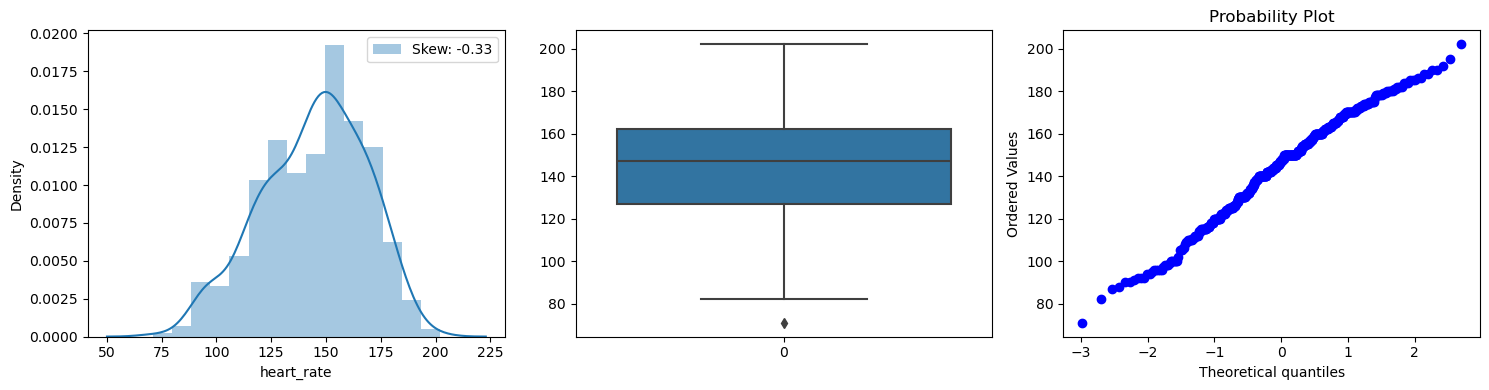

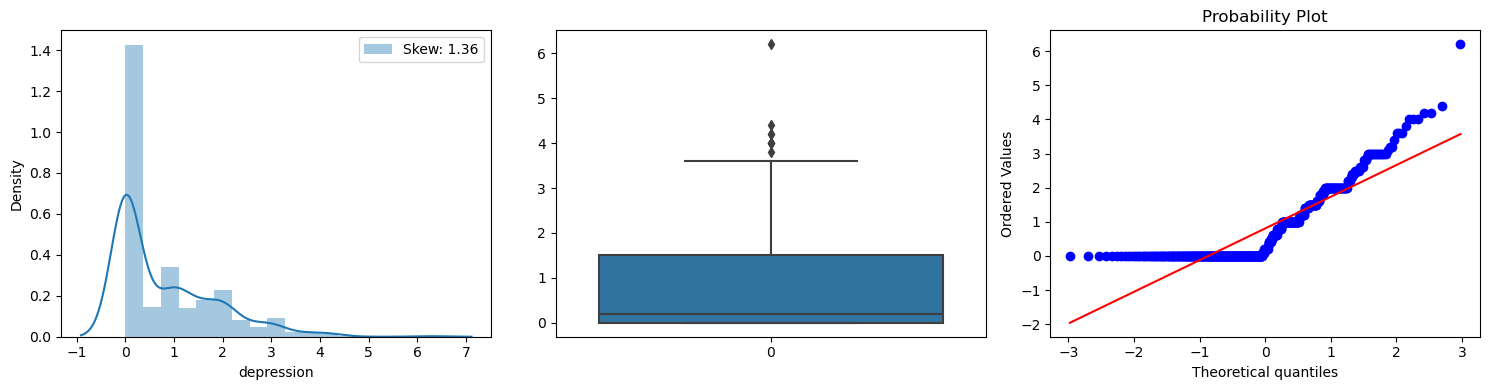

In [39]:
# Selected features for outlier analysis
outlier_new_win = ['blood_pressure', 'cholestoral', 'heart_rate', 'depression']

# Loop through each selected feature to visualize its distribution, box plot, and probability plot
for col in outlier_new_win:
    # Set up a figure with 1 row and 3 columns for the plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Distribution Plot
    sns.distplot(df_train[col], ax=axes[0], label=f"Skew: {np.round(df_train[col].skew(), 2)}")
    axes[0].legend()

    # Box Plot
    sns.boxplot(df_train[col], ax=axes[1])
    
    # Probability Plot
    stats.probplot(df_train[col], plot=axes[2])

    # Automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout()
    # Display the plots
    plt.show()

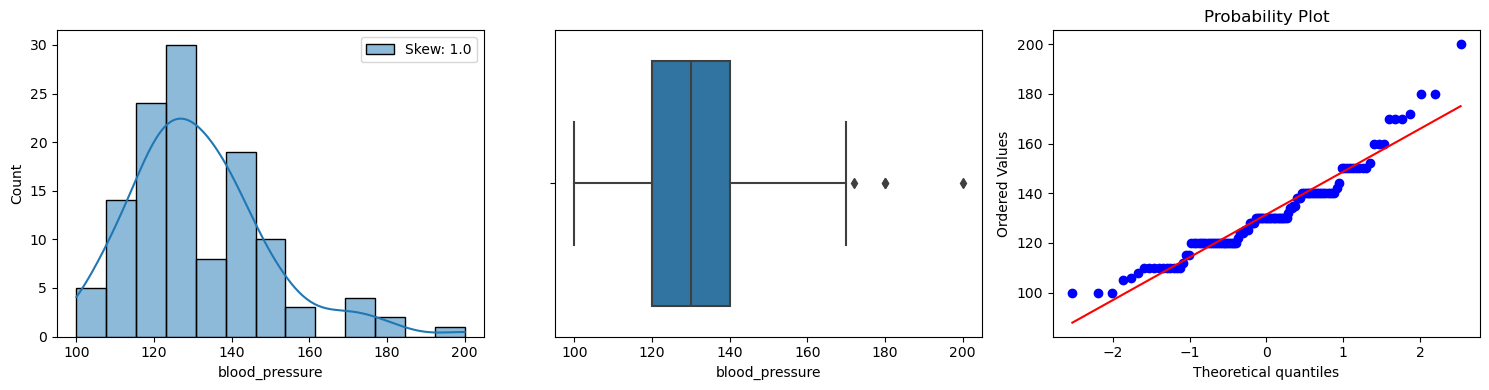

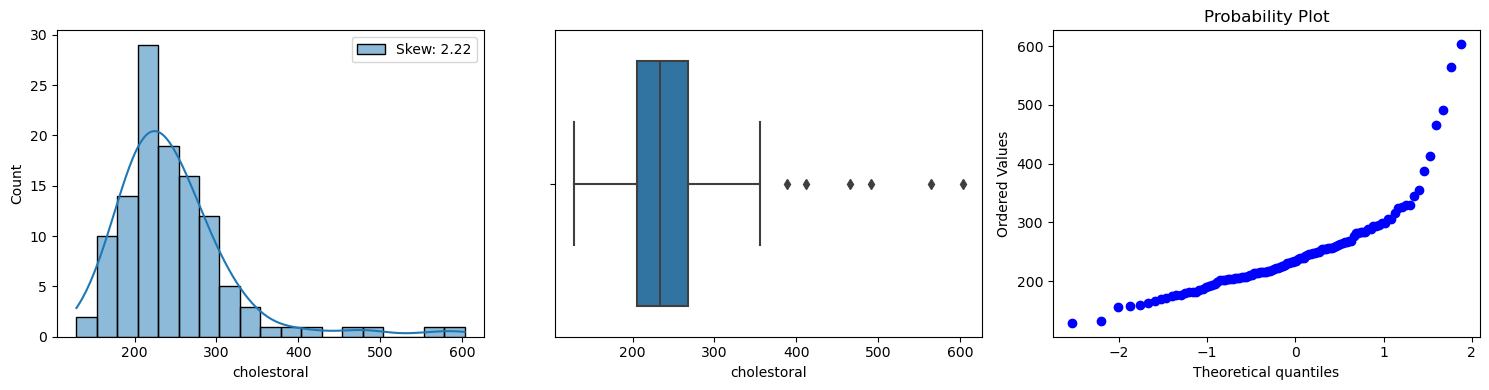

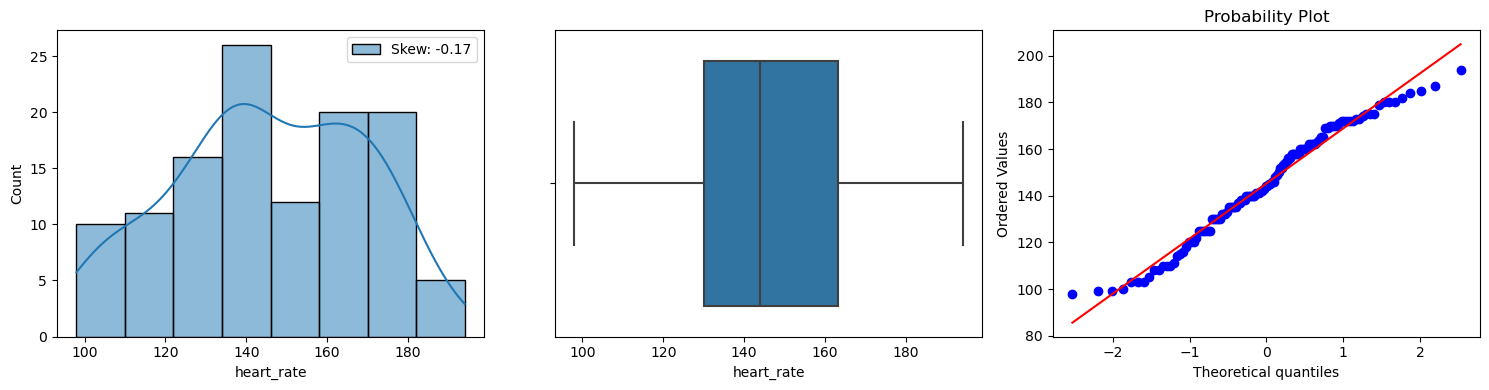

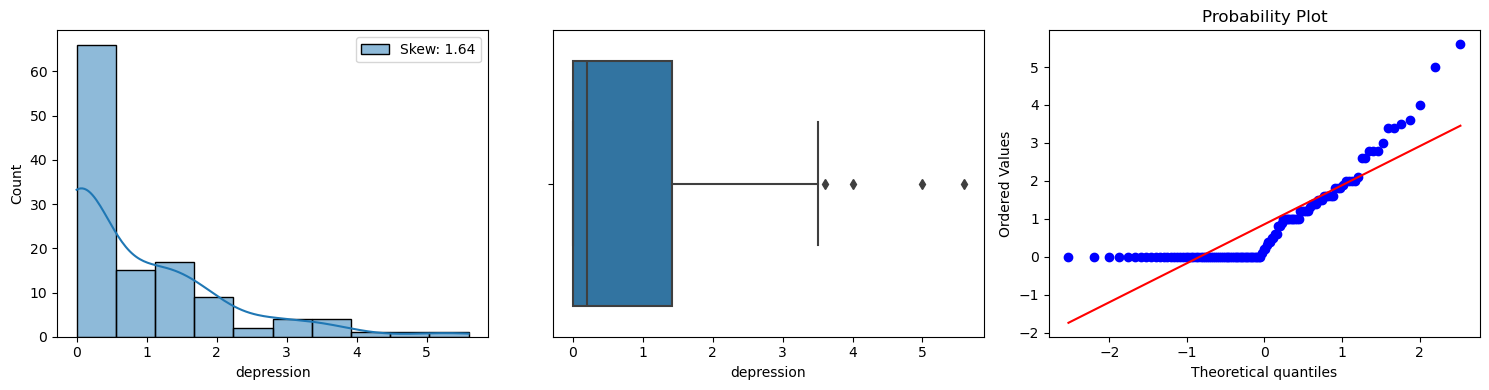

In [38]:

# Selected features for outlier analysis
outlier_new_win = ['blood_pressure', 'cholestoral', 'heart_rate', 'depression']

# Loop through each selected feature to visualize its distribution, box plot, and probability plot in the validation set
for col in outlier_new_win:
    # Set up a figure with 1 row and 3 columns for the plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Distribution Plot
    sns.histplot(df_val[col], ax=axes[0], kde=True, label=f"Skew: {np.round(df_val[col].skew(), 2)}")
    axes[0].legend()

    # Box Plot, corrected to use 'x=' for specifying the column data
    sns.boxplot(x=df_val[col], ax=axes[1])
    
    # Probability Plot
    stats.probplot(df_val[col], plot=axes[2])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


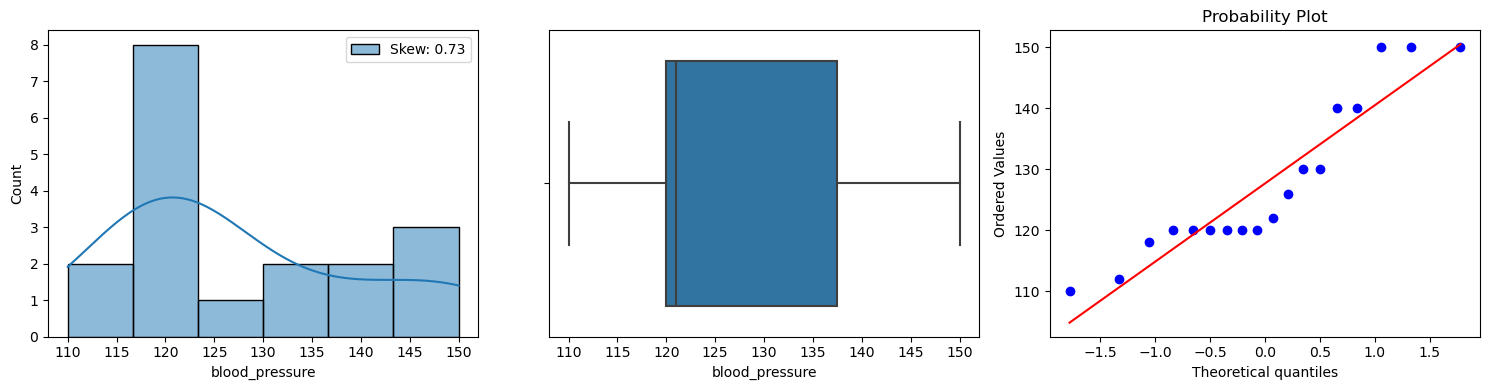

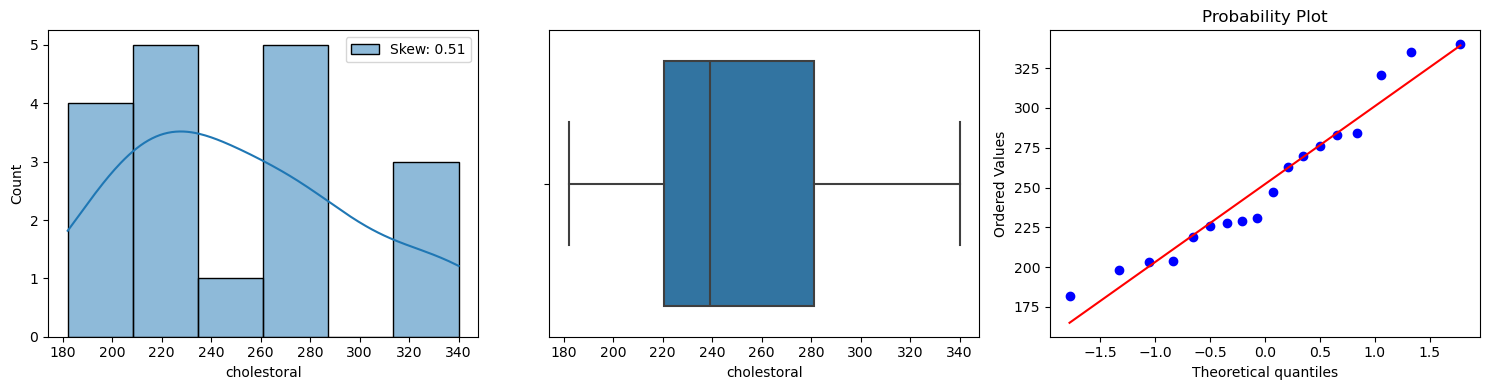

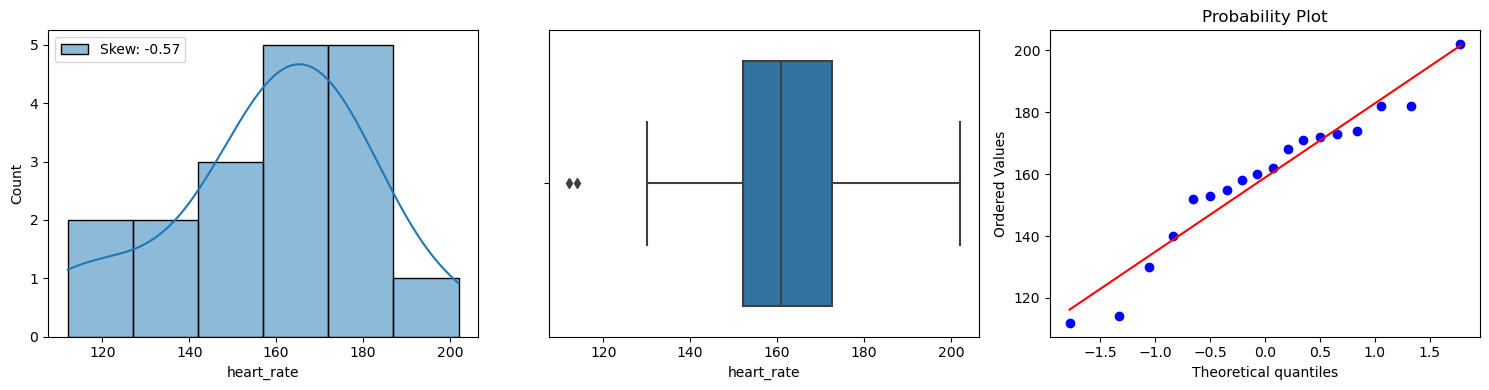

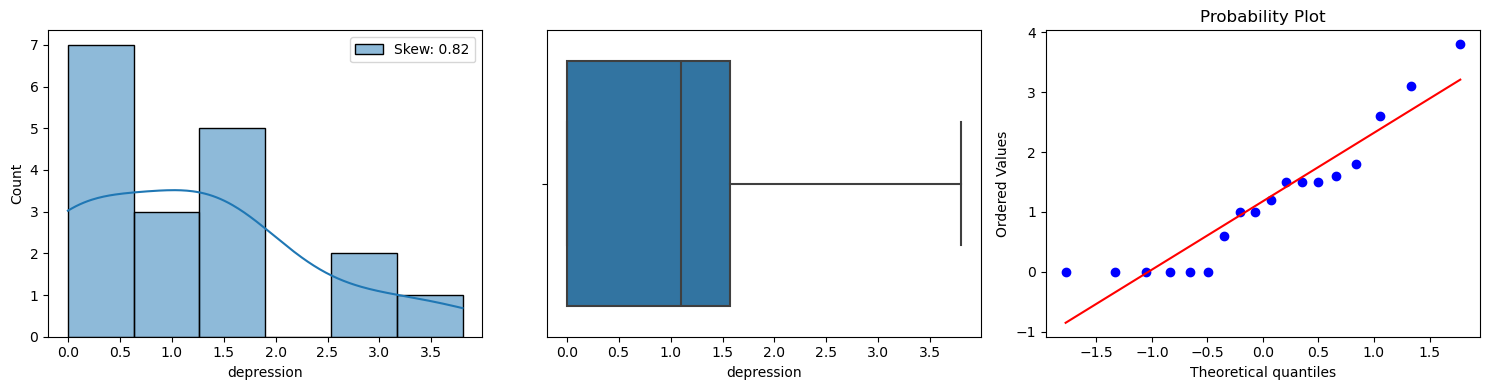

In [40]:
# Selected features for outlier analysis
outlier_new_win = ['blood_pressure', 'cholestoral', 'heart_rate', 'depression']

# Loop through each selected feature to visualize its distribution, box plot, and probability plot in the test set
for col in outlier_new_win:
    # Set up a figure with 1 row and 3 columns for the plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Distribution Plot using sns.histplot (since sns.distplot is deprecated)
    sns.histplot(df_test[col], ax=axes[0], kde=True, label=f"Skew: {np.round(df_test[col].skew(), 2)}")
    axes[0].legend()

    # Box Plot, corrected to use 'x=' for specifying the column data
    sns.boxplot(x=df_test[col], ax=axes[1])
    
    # Probability Plot
    stats.probplot(df_test[col], plot=axes[2])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


In [64]:
# Copies of the training set prepared for outlier capping at thresholds 0.01 and 0.05
df_train_capped_01 = df_train.copy()
df_train_capped_05 = df_train.copy()

# Copies of the validation set prepared for outlier capping at thresholds 0.01 and 0.05
df_val_capped_01 = df_val.copy()
df_val_capped_05 = df_val.copy()

# Copies of the test set prepared for outlier capping at thresholds 0.01 and 0.05
df_test_capped_01 = df_test.copy()
df_test_capped_05 = df_test.copy()


In [47]:
# Applying percentile capping with winsorization to the training, validation, and test sets
# for columns specified in outlier_new_win, capping outliers at the 0.01 thresholds.
percentile_capping_with_winsorize(df_train_capped_01, outlier_new_win, 0.01, 0.01)
percentile_capping_with_winsorize(df_val_capped_01, outlier_new_win, 0.01, 0.01)
percentile_capping_with_winsorize(df_test_capped_01, outlier_new_win, 0.01, 0.01)

In [65]:
df_train[outlier_new_win].describe().T

,count,mean,std,min,25%,50%,75%,max
blood_pressure,476.0,132.296218,17.609282,92.0,120.0,130.0,140.0,200.0
cholestoral,457.0,249.083151,55.600960,85.0,212.0,244.0,280.0,529.0
heart_rate,476.0,144.256303,23.885725,71.0,127.0,147.0,162.0,202.0
depression,477.0,0.806080,1.044144,0.0,0.0,0.2,1.5,6.2


In [66]:
# Apply percentile capping to training, validation, and test sets for specified features.
# This process caps outliers in the 'outlier_new_win' columns at the 1st and 99th percentiles,
# effectively reducing the impact of extreme outliers without significantly altering the overall distribution.
# It ensures that the data analysis and subsequent modeling are less influenced by extreme values,
# maintaining the integrity and general characteristics of the dataset's distribution.
percentile_capping(df_train_capped_01, outlier_new_win, 0.01, 0.01)
percentile_capping(df_val_capped_01, outlier_new_win, 0.01, 0.01)
percentile_capping(df_test_capped_01, outlier_new_win, 0.01, 0.01)


In [67]:
df_train_capped_01[outlier_new_win].describe().T

,count,mean,std,min,25%,50%,75%,max
blood_pressure,476.0,132.254202,17.233886,100.0,120.0,130.0,140.0,180.00
cholestoral,457.0,248.694530,52.376262,136.6,212.0,244.0,280.0,407.88
heart_rate,476.0,144.267857,23.597685,90.0,127.0,147.0,162.0,188.50
depression,477.0,0.799790,1.019443,0.0,0.0,0.2,1.5,4.00


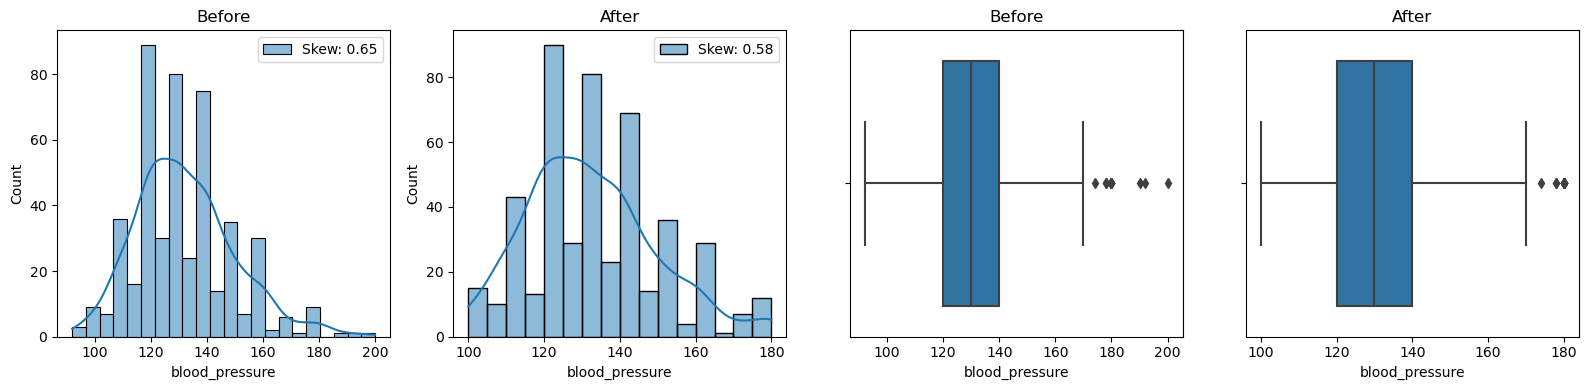

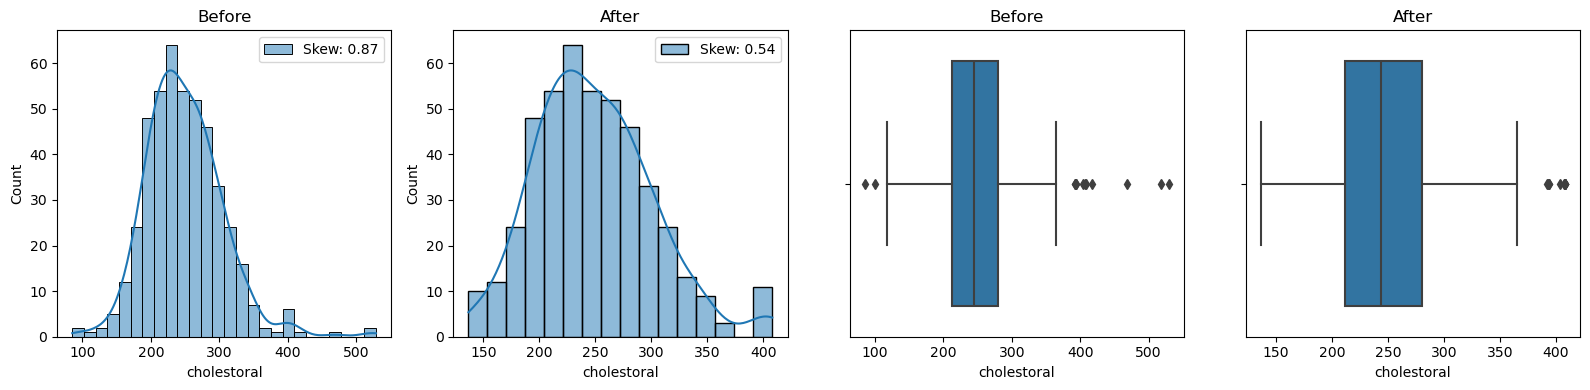

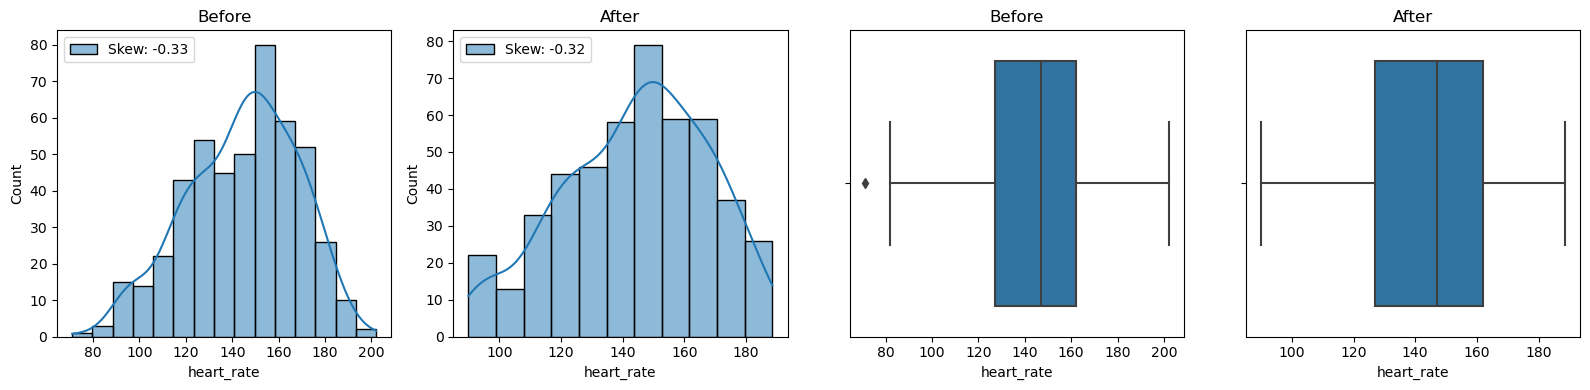

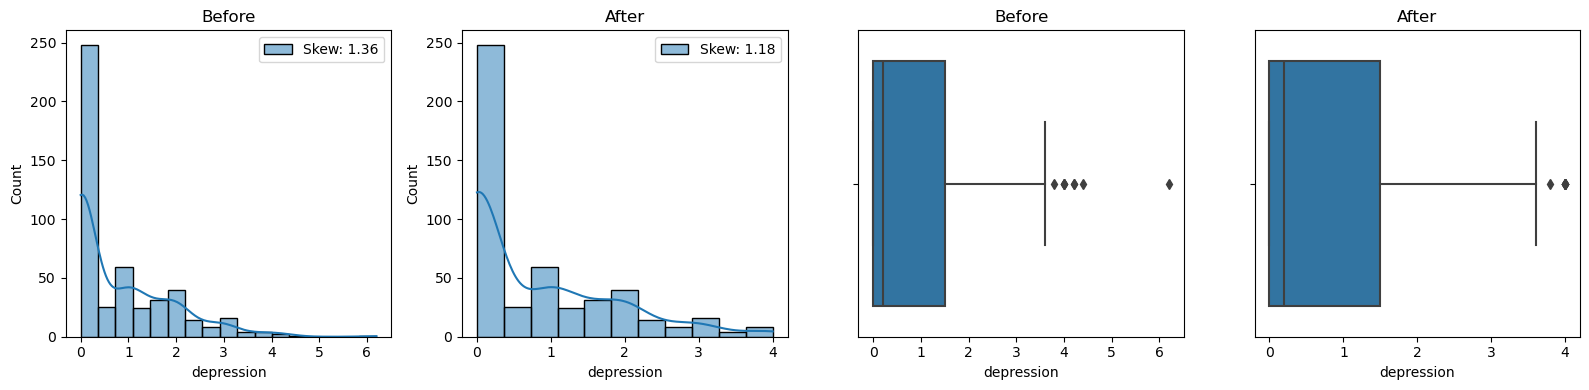

In [68]:
# Selected features for outlier analysis
outlier_new_win = ['blood_pressure', 'cholestoral', 'heart_rate', 'depression']

# Loop through each selected feature to visualize its distribution and box plots before and after capping in the training set
for col in outlier_new_win:
    # Set up a figure with 1 row and 4 columns for the plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Distribution Plot before capping using sns.histplot
    sns.histplot(df_train[col], ax=axes[0], kde=True, label=f"Skew: {np.round(df_train[col].skew(), 2)}")
    axes[0].set_title('Before')
    axes[0].legend()

    # Distribution Plot after capping using sns.histplot
    sns.histplot(df_train_capped_01[col], ax=axes[1], kde=True, label=f"Skew: {np.round(df_train_capped_01[col].skew(), 2)}")
    axes[1].set_title('After')
    axes[1].legend()

    # Box Plot before capping
    sns.boxplot(x=df_train[col], ax=axes[2])
    axes[2].set_title('Before')
    
    # Box Plot after capping
    sns.boxplot(x=df_train_capped_01[col], ax=axes[3])
    axes[3].set_title('After')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


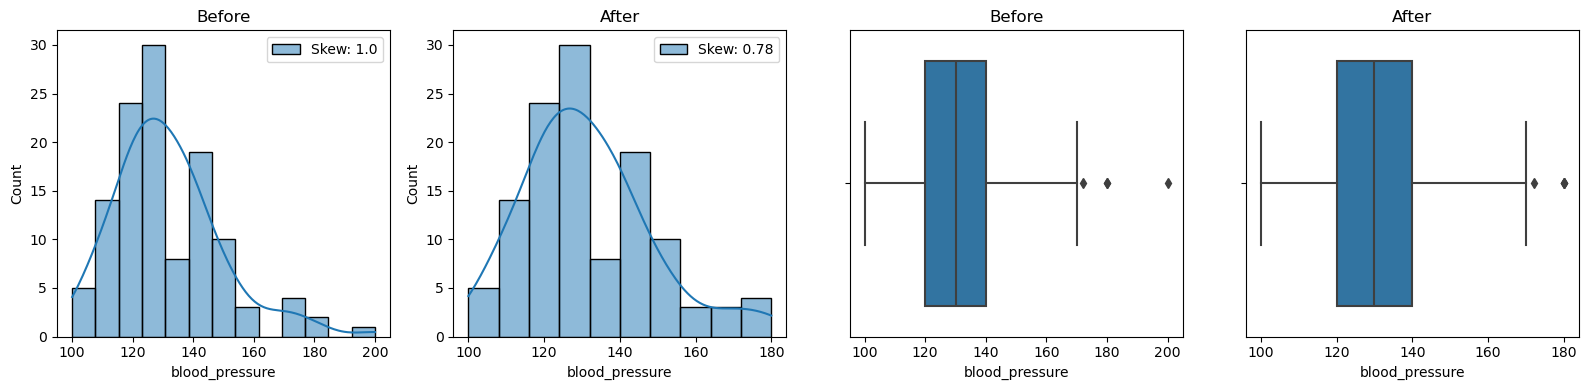

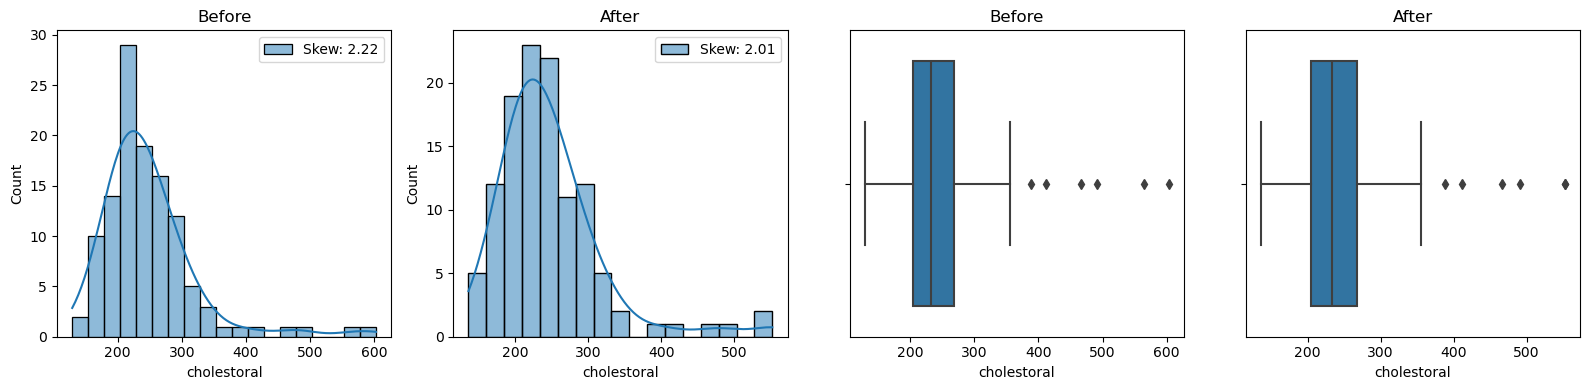

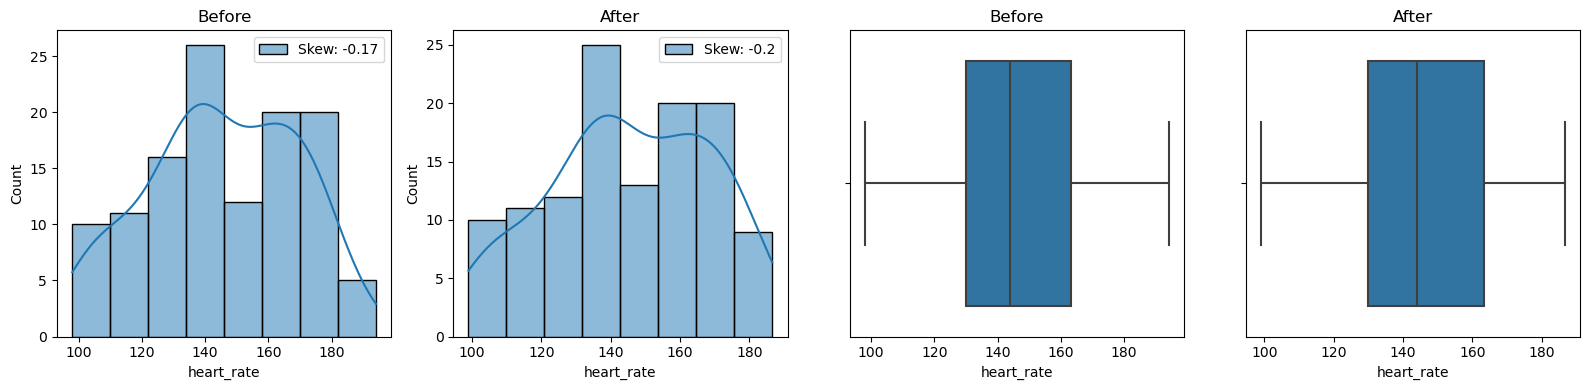

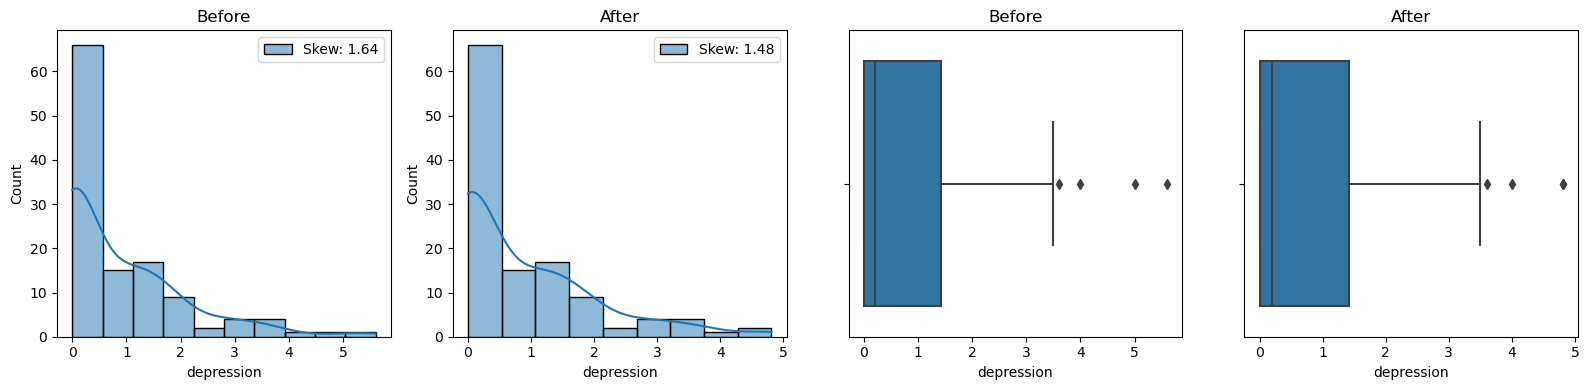

In [69]:
# Loop through each selected feature to visualize its distribution and box plots before and after capping in the validation set
for col in outlier_new_win:
    # Set up a figure with 1 row and 4 columns for the plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Distribution Plot before capping using sns.histplot
    sns.histplot(df_val[col], ax=axes[0], kde=True, label=f"Skew: {np.round(df_val[col].skew(), 2)}")
    axes[0].set_title('Before')
    axes[0].legend()

    # Distribution Plot after capping using sns.histplot
    sns.histplot(df_val_capped_01[col], ax=axes[1], kde=True, label=f"Skew: {np.round(df_val_capped_01[col].skew(), 2)}")
    axes[1].set_title('After')
    axes[1].legend()

    # Box Plot before capping
    sns.boxplot(x=df_val[col], ax=axes[2])
    axes[2].set_title('Before')
    
    # Box Plot after capping
    sns.boxplot(x=df_val_capped_01[col], ax=axes[3])
    axes[3].set_title('After')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


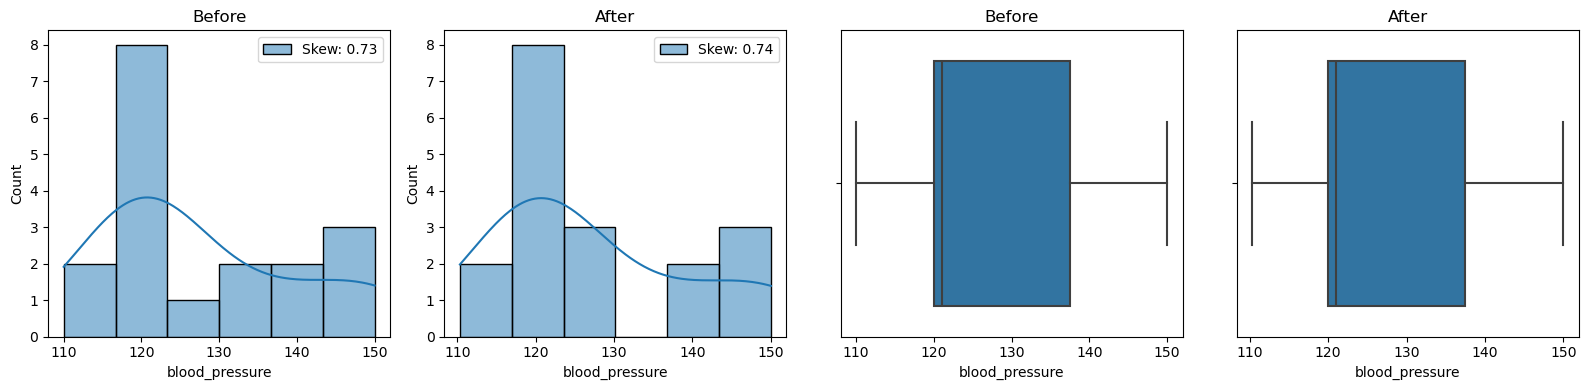

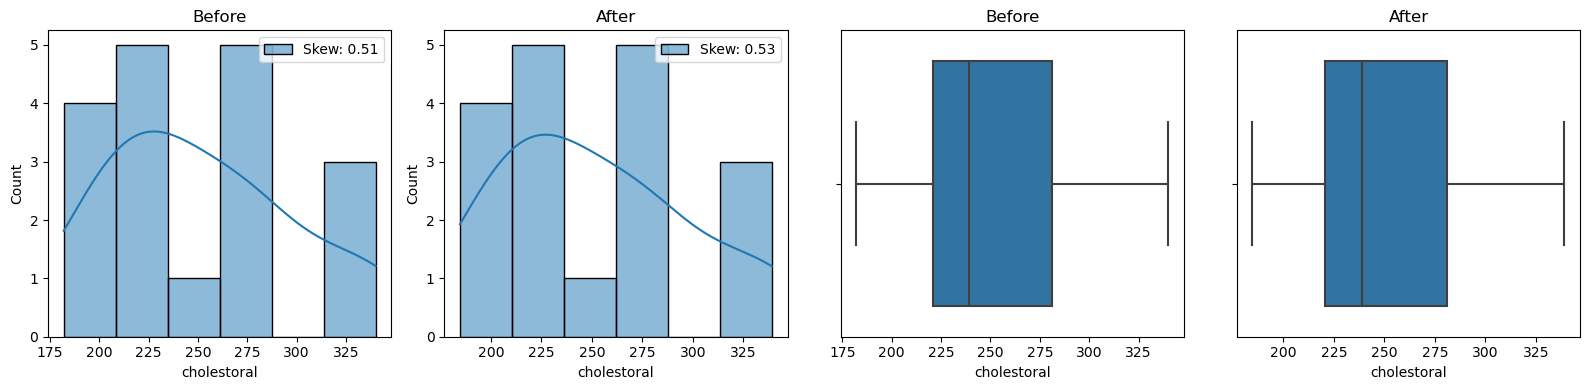

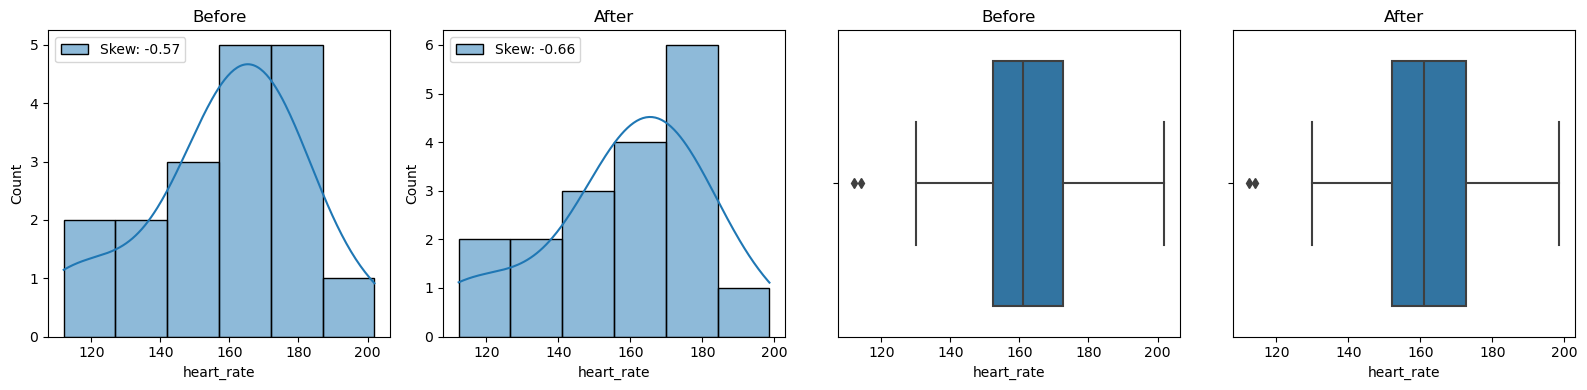

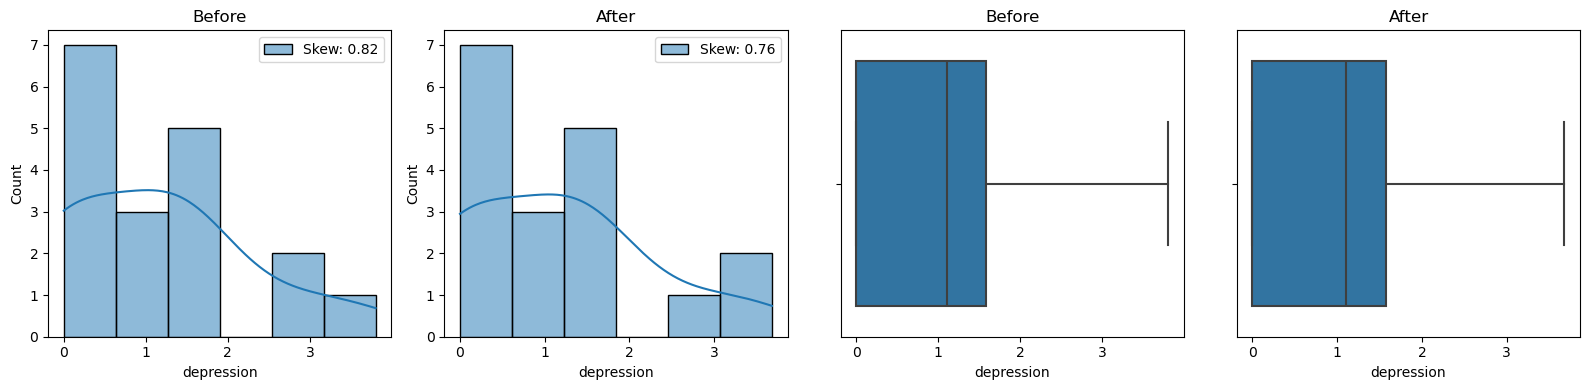

In [70]:
# Loop through each selected feature to visualize its distribution and box plots before and after capping in the test set
for col in outlier_new_win:
    # Set up a figure with 1 row and 4 columns for the plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Distribution Plot before capping using sns.histplot
    sns.histplot(df_test[col], ax=axes[0], kde=True, label=f"Skew: {np.round(df_test[col].skew(), 2)}")
    axes[0].set_title('Before')
    axes[0].legend()

    # Distribution Plot after capping using sns.histplot
    sns.histplot(df_test_capped_01[col], ax=axes[1], kde=True, label=f"Skew: {np.round(df_test_capped_01[col].skew(), 2)}")
    axes[1].set_title('After')
    axes[1].legend()

    # Box Plot before capping
    sns.boxplot(x=df_test[col], ax=axes[2])
    axes[2].set_title('Before')
    
    # Box Plot after capping
    sns.boxplot(x=df_test_capped_01[col], ax=axes[3])
    axes[3].set_title('After')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


## "Handling Missing Values"

In [71]:
print("Train:")
print(df_train_capped_01.isnull().sum())

print("\n*********************\n")
print("Val:")
print(df_val_capped_01.isnull().sum())

print("\n*********************\n")
print("Test:")
print(df_test_capped_01.isnull().sum())
# Note: df_test_capped_01 doesn't have any missing value

Train:
Age                       0
sex                       0
chest_pain                0
blood_pressure            1
cholestoral              20
blood_sugar               6
electrocardiographic      1
heart_rate                1
exercise_induced          1
depression                0
slope                   149
ca                      237
thal                    214
c                         0
dtype: int64

*********************

Val:
Age                      0
sex                      0
chest_pain               0
blood_pressure           0
cholestoral              3
blood_sugar              2
electrocardiographic     0
heart_rate               0
exercise_induced         0
depression               0
slope                   41
ca                      57
thal                    54
c                        0
dtype: int64

*********************

Test:
Age                     0
sex                     0
chest_pain              0
blood_pressure          0
cholestoral             0
blood_su

In [72]:
# Evaluating Missing Data Percentage in the Training Dataset After Outlier Capping
# This step helps to understand the extent of missing data in each column as a percentage,
# providing insights into the necessity for further data cleaning or imputation.

print("Train:")
# Display the percentage of missing values per column in the training set after outlier capping at 0.01 threshold
print(df_train_capped_01.isnull().mean() * 100)


Train:
Age                      0.000000
sex                      0.000000
chest_pain               0.000000
blood_pressure           0.209644
cholestoral              4.192872
blood_sugar              1.257862
electrocardiographic     0.209644
heart_rate               0.209644
exercise_induced         0.209644
depression               0.000000
slope                   31.236897
ca                      49.685535
thal                    44.863732
c                        0.000000
dtype: float64


In [73]:
df_train_capped_01[['blood_sugar', 'electrocardiographic', 'exercise_induced']].mode()

,blood_sugar,electrocardiographic,exercise_induced
0,0.0,0.0,0.0


In [74]:
# Imputing missing values and dropping sparse columns in the training data after outlier capping

# Fill missing values in specified columns with their median values
df_train_capped_01[['blood_pressure', 'cholestoral', 'heart_rate']] = df_train_capped_01[['blood_pressure', 'cholestoral', 'heart_rate']].fillna(df_train_capped_01[['blood_pressure', 'cholestoral', 'heart_rate']].median())

# Drop columns with fewer than 400 non-null values to focus on more complete features
df_train_capped_01 = df_train_capped_01.dropna(thresh=400, axis=1)

# Fill missing values in specified columns with 0.0, assuming absence of a value indicates a normal level or lack of condition
df_train_capped_01[['blood_sugar', 'electrocardiographic', 'exercise_induced']] = df_train_capped_01[['blood_sugar', 'electrocardiographic', 'exercise_induced']].fillna(0.0)

# Check for remaining missing values in the dataset
df_train_capped_01.isnull().sum()


Age                     0
sex                     0
chest_pain              0
blood_pressure          0
cholestoral             0
blood_sugar             0
electrocardiographic    0
heart_rate              0
exercise_induced        0
depression              0
c                       0
dtype: int64

In [75]:
# Evaluating the percentage of missing data in the validation dataset after outlier capping
# This helps to identify the extent of missing data in each column as a percentage,
# guiding further data cleaning or imputation strategies.

print("Val:")
# Display the percentage of missing values per column in the validation set after outlier capping at the 0.01 threshold
print(df_val_capped_01.isnull().mean() * 100)


Val:
Age                      0.000000
sex                      0.000000
chest_pain               0.000000
blood_pressure           0.000000
cholestoral              2.500000
blood_sugar              1.666667
electrocardiographic     0.000000
heart_rate               0.000000
exercise_induced         0.000000
depression               0.000000
slope                   34.166667
ca                      47.500000
thal                    45.000000
c                        0.000000
dtype: float64


In [76]:
df_val_capped_01[['blood_sugar']].mode()

,blood_sugar
0,0.0


In [77]:
# Imputing missing values and adjusting the dataset structure for the validation data post-outlier capping

# Fill missing values in the 'cholestoral' column with its median value
df_val_capped_01['cholestoral'] = df_val_capped_01['cholestoral'].fillna(df_val_capped_01['cholestoral'].median())

# Fill missing values in the 'blood_sugar' column with 0.0, assuming absence indicates a normal level
df_val_capped_01['blood_sugar'] = df_val_capped_01['blood_sugar'].fillna(0.0)

# Drop the 'slope', 'ca', and 'thal' columns from the dataset, if not relevant or too sparse
df_val_capped_01.drop(['slope', 'ca', 'thal'], axis=1, inplace=True)

# Check for remaining missing values in the dataset to ensure completeness
df_val_capped_01.isnull().sum()


Age                     0
sex                     0
chest_pain              0
blood_pressure          0
cholestoral             0
blood_sugar             0
electrocardiographic    0
heart_rate              0
exercise_induced        0
depression              0
c                       0
dtype: int64

In [78]:
print("Train:")
print(df_train_capped_01.columns)
print(df_train_capped_01.shape)

print("\n*********************\n")
print("Val:")
print(df_val_capped_01.columns)
print(df_val_capped_01.shape)

print("\n*********************\n")
print("Test:")
print(df_test_capped_01.columns)
print(df_test_capped_01.shape)

Train:
Index(['Age', 'sex', 'chest_pain', 'blood_pressure', 'cholestoral',
       'blood_sugar', 'electrocardiographic', 'heart_rate', 'exercise_induced',
       'depression', 'c'],
      dtype='object')
(477, 11)

*********************

Val:
Index(['Age', 'sex', 'chest_pain', 'blood_pressure', 'cholestoral',
       'blood_sugar', 'electrocardiographic', 'heart_rate', 'exercise_induced',
       'depression', 'c'],
      dtype='object')
(120, 11)

*********************

Test:
Index(['Age', 'sex', 'chest_pain', 'blood_pressure', 'cholestoral',
       'blood_sugar', 'electrocardiographic', 'heart_rate', 'exercise_induced',
       'depression', 'slope', 'ca', 'thal'],
      dtype='object')
(18, 13)


In [79]:
df_test_capped_01.drop(['slope', 'ca', 'thal'], axis=1, inplace=True)
df_test_capped_01.head()

,Age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,electrocardiographic,heart_rate,exercise_induced,depression
0,43,0,2,122.0,263.00,0,0,173.0,0,0.0
1,59,1,1,140.0,283.00,1,1,162.0,1,1.0
2,58,0,3,120.0,339.15,1,0,172.0,0,0.0
3,69,0,1,150.0,226.00,0,0,114.0,1,2.6
4,42,0,4,150.0,247.00,0,1,171.0,0,1.5


## "Handling Duplicate Values"

In [80]:
# Checking for Duplicated Rows in Datasets After Outlier Capping

# Train Dataset
# This line prints the number of duplicated rows in the training dataset after outlier capping.
# Duplicated rows might indicate redundant data that could be removed to prevent overfitting.
print("Train:")
print(df_train_capped_01.loc[df_train_capped_01.duplicated()].shape)

print("\n*********************\n")

# Validation Dataset
# Here, we check for duplicated rows in the validation dataset after outlier capping.
# The absence of duplicates (as indicated by the shape being (0, n)) suggests clean, unique data.
print("Val:")
print(df_val_capped_01.loc[df_val_capped_01.duplicated()].shape)
# Note: The validation dataset does not contain any duplicate values, indicating clean data ready for model validation.

print("\n*********************\n")

# Test Dataset
# Similar to the validation set, we check for duplicates in the test dataset after outlier capping.
# No duplicates would mean the test data is unique, ensuring an unbiased evaluation of the model.
print("Test:")
print(df_test_capped_01.loc[df_test_capped_01.duplicated()].shape)
# Note: The test dataset also does not contain any duplicate values, affirming the uniqueness of the test data.


Train:
(1, 11)

*********************

Val:
(0, 11)

*********************

Test:
(0, 10)


In [81]:
df_dup_capped_01 = df_train_capped_01.drop_duplicates()
print(df_train_capped_01.shape, df_dup_capped_01.shape)

(477, 11) (476, 11)


## Train/Test Split & Normalization

In [82]:
# Separating Features and Target Variable for Training and Validation Datasets After Outlier Capping and Duplicate Removal

# Assuming 'df_dup_0_01' refers to the training dataset 'df_train_capped_01' after duplicate removal,
# Training Dataset
# Dropping the target column 'c' to create the features dataset 'x_train_capped_01'
x_train_capped_01 = df_train_capped_01.drop('c', axis=1)
# Extracting the target column 'c' to create the target dataset 'y_train_capped_01'
y_train_capped_01 = df_train_capped_01['c']

# -----------------------------

# Validation Dataset
# Dropping the target column 'c' to create the features dataset 'x_val_capped_01'
x_val_capped_01 = df_val_capped_01.drop('c', axis=1)
# Extracting the target column 'c' to create the target dataset 'y_val_capped_01'
y_val_capped_01 = df_val_capped_01['c']


In [83]:
# Preparing the Test Dataset After Outlier Capping

# Creating a copy of the test dataset after outlier capping for feature analysis

x_test_capped_01 = df_test_capped_01.copy()

# Displaying the first few rows of the prepared test dataset to verify its structure and contents
x_test_capped_01.head()


,Age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,electrocardiographic,heart_rate,exercise_induced,depression
0,43,0,2,122.0,263.00,0,0,173.0,0,0.0
1,59,1,1,140.0,283.00,1,1,162.0,1,1.0
2,58,0,3,120.0,339.15,1,0,172.0,0,0.0
3,69,0,1,150.0,226.00,0,0,114.0,1,2.6
4,42,0,4,150.0,247.00,0,1,171.0,0,1.5


In [84]:
# Initialize the MinMaxScaler
scale_capped_01 = MinMaxScaler()

# Get the columns from the training dataset for consistency across datasets
columns = x_train_capped_01.columns

# Scale the training dataset and apply the same transformation to the validation and test datasets
# to ensure consistency in feature magnitudes across all datasets

# Training Dataset
# Fit the scaler on the training dataset and transform it
x_train_capped_01[columns] = scale_capped_01.fit_transform(x_train_capped_01[columns])

# Validation Dataset
# Transform the validation dataset using the scaler fitted on the training dataset
x_val_capped_01[columns] = scale_capped_01.transform(x_val_capped_01[columns])

# Test Dataset
# Transform the test dataset using the scaler fitted on the training dataset
x_test_capped_01[columns] = scale_capped_01.transform(x_test_capped_01[columns])


In [85]:
x_train_capped_01.head()

,Age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,electrocardiographic,heart_rate,exercise_induced,depression
239,0.125000,0.0,0.0,0.250,0.086258,0.0,0.5,0.964467,0.0,0.00
490,0.520833,1.0,1.0,0.500,0.395901,0.0,0.0,0.284264,1.0,0.00
590,0.416667,1.0,1.0,0.350,0.277942,0.0,0.0,0.060914,1.0,0.00
181,0.500000,1.0,1.0,0.300,0.454881,0.0,0.5,0.223350,1.0,0.75
570,0.750000,0.0,1.0,0.625,0.325863,0.0,1.0,0.243655,0.0,0.25


In [86]:
x_val_capped_01.head()

,Age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,electrocardiographic,heart_rate,exercise_induced,depression
405,0.333333,1.0,0.000000,0.1250,0.469625,0.0,0.0,0.426396,0.0,0.3
132,0.270833,1.0,0.333333,0.2500,0.583899,0.0,0.0,0.730964,0.0,0.0
211,0.312500,1.0,0.333333,0.3750,0.289000,0.0,0.0,0.456853,0.0,0.0
243,0.520833,1.0,0.333333,0.2500,0.403273,0.0,0.0,0.203046,0.0,0.0
85,0.791667,0.0,0.666667,0.1875,1.532439,0.0,1.0,0.710660,0.0,0.4


In [87]:
x_test_capped_01.head()

,Age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,electrocardiographic,heart_rate,exercise_induced,depression
0,0.291667,0.0,0.333333,0.275,0.465939,0.0,0.0,0.842640,0.0,0.000
1,0.625000,1.0,0.000000,0.500,0.539664,1.0,0.5,0.730964,1.0,0.250
2,0.604167,0.0,0.666667,0.250,0.746646,1.0,0.0,0.832487,0.0,0.000
3,0.833333,0.0,0.000000,0.625,0.329549,0.0,0.0,0.243655,1.0,0.650
4,0.270833,0.0,1.000000,0.625,0.406960,0.0,0.5,0.822335,0.0,0.375


## Hyperparameter Tunning

In [88]:
# Parameter grid for Decision Tree Classifier tuning
param_DT = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [2, 3, 4, 5, 6]
}

# Use the predefined GrdSrch_Tune function for grid search tuning of the Decision Tree Classifier
# on the training dataset with outlier capping applied
GrdSrch_Tune(DecisionTreeClassifier(random_state=100), x_train_capped_01, y_train_capped_01, param_DT)


best score is : 0.7843201754385964
best estimator is : DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=6,
                       random_state=100)
best Params is : {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 2}


0.7843201754385964

## "Modeling and Predicting with Decision Tree Classifier"

In [89]:
# Initializing the Decision Tree Classifier with specified hyperparameters
DT_capped_01 = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, random_state=100)

# Fitting the model on the training data with outlier capping
DT_capped_01.fit(x_train_capped_01, y_train_capped_01)

# Making predictions on the validation and training datasets with outlier capping
y_val_pred_capped_01 = DT_capped_01.predict(x_val_capped_01)
y_train_pred_capped_01 = DT_capped_01.predict(x_train_capped_01)

# Evaluating model performance on both training and validation datasets
val_acc_capped_01 = accuracy_score(y_val_capped_01, y_val_pred_capped_01)
train_acc_capped_01 = accuracy_score(y_train_capped_01, y_train_pred_capped_01)

# Performing 10-fold cross-validation to evaluate model accuracy
scores_capped_01 = cross_val_score(DT_capped_01, x_train_capped_01, y_train_capped_01, cv=10, scoring='accuracy')

# Calculating precision, recall, and F1 score for the validation dataset
precision_score_capped_01 = precision_score(y_val_capped_01, y_val_pred_capped_01)
recall_score_capped_01 = recall_score(y_val_capped_01, y_val_pred_capped_01)
f1_score_capped_01 = f1_score(y_val_capped_01, y_val_pred_capped_01)

# Generating confusion matrix for the validation dataset predictions
conf_capped_01 = confusion_matrix(y_val_capped_01, y_val_pred_capped_01)


print("Train set Accuracy: ", train_acc_capped_01)
print("Val set Accuracy: ", val_acc_capped_01)
print("Cross-validation Accuracy: %s\n" % scores_capped_01.mean())
print("************************************************")
print("Precision Score: ", precision_score_capped_01)
print("Recall Score: ", recall_score_capped_01)
print("F1 Score: ", f1_score_capped_01)
print("************************************************")
print("\nClassification Report:\n%s\n" % classification_report(y_val_capped_01, y_val_pred_capped_01))


Train set Accuracy:  0.8218029350104822
Val set Accuracy:  0.8083333333333333
Cross-validation Accuracy: 0.7758421985815602

************************************************
Precision Score:  0.8461538461538461
Recall Score:  0.66
F1 Score:  0.7415730337078651
************************************************

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85        70
           1       0.85      0.66      0.74        50

    accuracy                           0.81       120
   macro avg       0.82      0.79      0.79       120
weighted avg       0.81      0.81      0.80       120




In [90]:
# Making predictions on the test dataset with the Decision Tree model
predictions_capped_01 = DT_capped_01.predict(x_test_capped_01)

# Copying the test dataset and reversing the MinMax scaling transformation to return features to their original scale
x_test_with_pred_capped_01 = x_test_capped_01.copy()
columns = x_test_with_pred_capped_01.columns  # Assuming you want to reverse scaling on all columns
x_test_with_pred_capped_01[columns] = scale_capped_01.inverse_transform(x_test_with_pred_capped_01[columns])

# Appending the model's predictions as a new column
x_test_with_pred_capped_01['Prediction'] = predictions_capped_01

# Display the test dataset with original features and predictions
x_test_with_pred_capped_01


,Age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,electrocardiographic,heart_rate,exercise_induced,depression,Prediction
0,43.0,0.0,2.0,122.00,263.00,0.0,0.0,173.00,0.0,0.000,0
1,59.0,1.0,1.0,140.00,283.00,1.0,1.0,162.00,1.0,1.000,0
2,58.0,0.0,3.0,120.00,339.15,1.0,0.0,172.00,0.0,0.000,0
3,69.0,0.0,1.0,150.00,226.00,0.0,0.0,114.00,1.0,2.600,1
4,42.0,0.0,4.0,150.00,247.00,0.0,1.0,171.00,0.0,1.500,0
5,52.0,1.0,4.0,140.00,203.00,1.0,2.0,155.00,0.0,3.100,1
6,46.0,1.0,2.0,120.00,229.00,0.0,0.0,168.00,1.0,1.000,0
7,58.0,0.0,2.0,110.34,284.00,1.0,0.0,160.00,0.0,1.800,0
8,63.0,1.0,3.0,130.00,335.00,0.0,2.0,158.00,1.0,0.000,0
9,55.0,0.0,4.0,150.00,276.00,1.0,1.0,112.34,0.0,0.600,0
